<a href="https://colab.research.google.com/github/BenJMaurel/Wine_project/blob/main/wine_project_Julien_VF1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Quelques imports de bon fonctionnement

The general idea of this project is to design a way for a casual wine enthusiast to know if a wine is good or not just thanks to a critic of someone commonly known as a "good wine taster".

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
import random as rd
import urllib
import bs4
import pandas as pd
import numpy as np
from urllib import request

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

In [4]:
import csv
#Permet de lire facilement le fichier GloVe (vectorisation des mots dans un evn de dim 50)
def read_glove_vecs(glove_file):
    with open(glove_file, 'r', encoding='utf-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [5]:
def convert_to_one_hot(vecteur):
    n_values = int(np.max(vecteur) + 1)
    oh = np.eye(n_values)[vecteur]
    return oh

In [6]:
data = pd.read_csv("/content/drive/My Drive/Wine_project/winemag-data-130k-v2.csv")

In [7]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('/content/drive/My Drive/Wine_project/glove.6B.50d.txt')

#Introduction
Lorsque l'on soughaite acheter un vin, on sait immédiatement que la qualité de ce dernier est primordial. Pour les vrais connaisseurs, il suffit de se pencher sur la description de celui-ci pour déterminer sa qualité. Néanmoins, cette description n'est pas quantitative et pour des personnes moins habituées, il devient alors plus compliqué de connaître sa qualité. C'est pourquoi des experts déterminent des notes aux vins afin de savoir immédiatement si le vin est de bonne ou de mauvaise qualité. Ces notes sont données sur 100 mais varient qu'entre 80 et 100.

Mais ces notes ne sont pas toujours directement accessible sur la bouteille, il serait donc intéressant à partir de la description du vin de déterminer sa note.

C'est ce que nous allons faire par la suite dans ce projet : déterminer le score d'un vin sur 100 à partir de sa description.

Nous allons dans un premier temps, dans le but de tester les modèles mis en oeuvre, séparer les scores des vins en 5 classes. Avec nos modèles, nous allons essayer de déterminer la classe d'un vin. Ensuite, en réutilisant les mêmes modèles, nous allons déterminer directement le score du vin. Pour finir, nous essaierons de tester notre modèle comme si nous étions des consommateurs sur des descriptions qui ne viennnent pas ne notre modèle.

# Bases de données
Nous allons, dans cette partie, vous présenter les bases de données que nous avons utilisés. 

## Base de données principale
Cette base de données a été récupéré sur Kaggle au lien suivant : https://www.kaggle.com/zynicide/wine-reviews?fbclid=IwAR2pnRkLQoCiTY4LncwDfT7PjwAtE0uI1ejNlfKp9O4ts9MuXNJ4QN07djY
Elle référence 129908 vins avec différentes informations comme le pays d'origine, le prix, la variété, le nom, etc...
Nous utiliserons principalement dans la suite les variables suivantes :

- description : variable str qui décrit le vin
- price : variable float qui donne le prix du vin
- points : variable float qui donne la note du vin sur 100

Vous pouvez observer cette base de données ci-dessous.

In [ ]:
data.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


## Base de données secondaire
Afin de tester notre modèle sur d'autres descriptions, et de nous familiariser avec le webscrapping, nous avons décider de créer une base de donénes à partir du site : https://www.leaandsandeman.co.uk/

Notre objectif étant de récupérer les descriptions, les noms des vins et leur prix. Nous allons donc vous présenter dans la suite le code qui nous a permis de webscrapper ce site.

Vous pouvez retrouver l'une des pages de ce site que nous avons webscrapper sur ce lien : https://www.leaandsandeman.co.uk/wine/2019-CABERNET-SAUVIGNON-Camina-37081-00.html?pack=37729&categoryFilter=24&page=0&sortOption=2&resultsPerPage=12&minResultsPerPage=12

Dans un premier temps, il faut donc savoir récupérer le prix, le nom et la description d'un vin à partir de sa page web :

In [8]:
def find_description(url):
  """
  This founction allows to find the description
  input :
    url   - str - link of the web page
  output :
    description of the wine of the web page
  """
  request_text = request.urlopen(url).read()
  page = bs4.BeautifulSoup(request_text,'lxml')
  return(page.findAll('meta',{'property' : 'og:description'})[0].get('content'))
  
def find_price(url):
  """
  This function allows to find the price
  input :
    url  - str - link of the web page
  output :
    price of the wine of the web page
  """
  request_text = request.urlopen(url).read()
  page = bs4.BeautifulSoup(request_text,'lxml')
  return(float(page.findAll('td',{'class' : 'price'})[0].findAll('span')[-1].text.replace(',','')))

  
def find_name(url):
  """
  This function allows to find te name
  input :
    url  - str - link of the web page
  output :
    price of the wine of the web page
  """
  request_text = request.urlopen(url).read()
  page = bs4.BeautifulSoup(request_text,'lxml')
  return(page.findAll('meta',{'name' : 'twitter:title'})[0].get('content'))

## Exemple ##

url1 = 'https://www.leaandsandeman.co.uk/wine/2018-CHATEAU-BELLE-GARDE-Bordeaux-44166-00.html?pack=39543&categoryFilter=30&page=0&sortOption=2&resultsPerPage=12&minResultsPerPage=12'
description = find_description(url1)
price =  find_price(url1)
name = find_name(url1)
print([description,price,name])

["From a good vintage and always delivering incredible value for money, Eric Duffau's brilliant Château Belle Garde is one of our longest standing listings. Leaf tea, cassis, plum and tobacco aromas are backed by a well balanced palate. Again dark fruited, with some nice tannic structure, this has lovely definition with the tobacco and cedar notes allowing for a sleek finish.", 11.5, '2018 CHÂTEAU BELLE GARDE Bordeaux']


Il faut ensuite s'intéresser à la récupération de l'ensemble des liens url. Le site web ne présentait au maximum que 48 vins sur sa page d'accueil, il a donc fallu enregistrer plusieurs url pour avoir accès à l'ensemble des vins.

In [113]:
## ensemble des pages regroupant 48 vins rouges ##
liste_url_general_redwine = ['https://www.leaandsandeman.co.uk/search.html?&resultsPerPage=48&page=0&minResultsPerPage=12&sortOption=2&categoryFilter=24','https://www.leaandsandeman.co.uk/search.html?&resultsPerPage=48&page=1&minResultsPerPage=12&sortOption=2&categoryFilter=24','https://www.leaandsandeman.co.uk/search.html?&resultsPerPage=48&page=2&minResultsPerPage=12&sortOption=2&categoryFilter=24','https://www.leaandsandeman.co.uk/search.html?&resultsPerPage=48&page=3&minResultsPerPage=12&sortOption=2&categoryFilter=24','https://www.leaandsandeman.co.uk/search.html?&resultsPerPage=48&page=4&minResultsPerPage=12&sortOption=2&categoryFilter=24','https://www.leaandsandeman.co.uk/search.html?&resultsPerPage=48&page=5&minResultsPerPage=12&sortOption=2&categoryFilter=24','https://www.leaandsandeman.co.uk/search.html?&resultsPerPage=48&page=6&minResultsPerPage=12&sortOption=2&categoryFilter=24','https://www.leaandsandeman.co.uk/search.html?&resultsPerPage=48&page=7&minResultsPerPage=12&sortOption=2&categoryFilter=24','https://www.leaandsandeman.co.uk/search.html?&resultsPerPage=48&page=8&minResultsPerPage=12&sortOption=2&categoryFilter=24']
## ensemble des pages regroupant 48 vins blancs ##
liste_url_general_whitewine = ['https://www.leaandsandeman.co.uk/search.html?&resultsPerPage=48&page=0&minResultsPerPage=12&sortOption=2&categoryFilter=52','https://www.leaandsandeman.co.uk/search.html?&resultsPerPage=48&page=1&minResultsPerPage=12&sortOption=2&categoryFilter=52','https://www.leaandsandeman.co.uk/search.html?&resultsPerPage=48&page=2&minResultsPerPage=12&sortOption=2&categoryFilter=52','https://www.leaandsandeman.co.uk/search.html?&resultsPerPage=48&page=3&minResultsPerPage=12&sortOption=2&categoryFilter=52','https://www.leaandsandeman.co.uk/search.html?&resultsPerPage=48&page=4&minResultsPerPage=12&sortOption=2&categoryFilter=52']
liste_url_general = liste_url_general_redwine + liste_url_general_whitewine
liste_url = []
for url_general in liste_url_general:
  request_text = request.urlopen(url_general).read()
  page = bs4.BeautifulSoup(request_text,'lxml')
  liste_a = page.findAll('a',{'class' : 'restit blue'})
  for ele in liste_a:
    liste_url.append(ele.get('href'))
print('Nous avons récupéré '+str(len(liste_url))+' url associés à des vins')

Nous avons récupéré 611 url associés à des vins


Une fois l'ensemble des url récupérés, il faut construire la base de données :
/!\ Webscrapper l'ensemble des urls peut être un problème. Assez souvent il retourne une erreur de connection au réseau et n'arrive pas à récupérer l'ensemble des données. Dans tous les cas, tout récupérer peut être un peu long.
C'est pourquoi nous avons enregistré les données dans un fichier csv.
Le programme ci-dessous récupère seulement les données de 25 urls pour vous montrer que ce code arrive à webscrapper. Vous pouvez retrouver en dessous la base de données en entier.

In [171]:
liste_url2 = liste_url[:25]
liste_nom = []
liste_prix = []
liste_avis = []
n=len(liste_url2)
p=0
for url in liste_url2:
  url = 'https://www.leaandsandeman.co.uk'+url
  request_text = request.urlopen(url).read()
  page = bs4.BeautifulSoup(request_text,'lxml')
  B = page.findAll('meta',{'property' : 'og:description'})[0].get('content')
  if B == '': #quand il n'y a pas de description
    liste_avis.append('NaN')
  else:
    liste_avis.append(B)
  A = page.findAll('td',{'class' : 'price'})
  if len(A) == 0: #quand le prix n'est pas indiqué sur le site
    liste_prix.append('NaN')
  else:
    liste_prix.append(float(page.findAll('td',{'class' : 'price'})[0].findAll('span')[-1].text.replace(',','')))
  liste_nom.append(page.findAll('meta',{'name' : 'twitter:title'})[0].get('content'))
  p+=1
  if p%5==0:
    print(str(p)+' url ont déjà été traité sur '+str(n))
data_annexe = pd.DataFrame(np.array([liste_nom,liste_prix,liste_avis]).T,columns=['nom','prix','avis'])
data_annexe.head()

40 url ont déjà été récupéré sur 211
80 url ont déjà été récupéré sur 211
120 url ont déjà été récupéré sur 211
160 url ont déjà été récupéré sur 211
200 url ont déjà été récupéré sur 211


,nom,prix,avis
0,2007 RECIOTO DELLA VALPOLICELLA Quintarelli,146.5,NaN
1,2014 MONTETI Tenuta Monteti,189.95,2014 is a vintage that really drove the cream ...
2,2006 CHÂTEAU PAVIE MACQUIN Grand Cru Classé Sa...,195.0,"The 2006 Château Pavie Macquin has a ripe, sen..."
3,2012 CHÂTEAU GLORIA Cru Bourgeois Saint Julien,235.0,"Plush and rounded, lively and winning with a g..."
4,2011 CLOS DES LAMBRAYS Grand Cru Domaine des L...,332.95,Rich nose of deep fruit and undergrowth. A hug...


In [95]:
data_annexe.shape

(50, 3)

In [192]:
## Just to save data_annexe ##
#data_annexe_txt = np.asarray(data_annexe)
#np.savetxt('data_annexe.csv', data_annexe_txt, delimiter=",", fmt='%s')

In [194]:
data_annexe = np.genfromtxt('/content/Wine_project/data_annexe.csv', delimiter=',')

OSError: ignored

On remarque que des données sont manquantes. Pour certains vin que le site n'a plus en stock, le site n'affiche pas le prix, il est alors indiqué NaN dans la base de données. Pour certains vins, il n'y a pas de description, dans ce cas, il est également indiqué NaN.

# Statistiques descriptives

In [ ]:
data_stat = data.copy()
data_stat = data_stat.drop('Unnamed: 0', axis = 1)
data_stat.columns


Index(['country', 'description', 'designation', 'points', 'price', 'province',
       'region_1', 'region_2', 'taster_name', 'taster_twitter_handle', 'title',
       'variety', 'winery'],
      dtype='object')

In [ ]:
data_stat['country'].nunique()
data_stat['region_2'].nunique()
data_stat['province'].count()

129908

In [ ]:
data_stat.describe()

,points,price
count,129971.000000,120975.000000
mean,88.447138,35.363389
std,3.039730,41.022218
min,80.000000,4.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,3300.000000


On remarque ici que les notes, même si elles sont données sur 100, ne varient que entre 80 et 100.

In [ ]:
data_stat.isnull().sum()

country                     63
description                  0
designation              37465
points                       0
price                     8996
province                    63
region_1                 21247
region_2                 79460
taster_name              26244
taster_twitter_handle    31213
title                        0
variety                      1
winery                       0
dtype: int64

## Etude de la variable 'points'
Dans un premier temps, nous allons étudier la variable 'points' qui est une variable chiffrée entre 80 et 100 et qui détermine la qualité du vin.

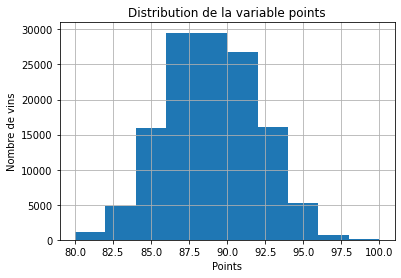

In [ ]:
fig = data_stat['points'].hist()
plt.xlabel('Points')
plt.ylabel('Nombre de vins')
plt.title('Distribution de la variable points')
plt.show()

Comme on peut s'y attendre, la distribution des notes n'est pas équitable. Il y a beaucoup de vins notés entre 85 et 95, et très peu pour des notes très faibles ou très fortes. Cette distribution pourra poser problème par la suite pour réussir à déterminer 

Par la suite, on regroupera les points dans 5 groupes différents. On créé alors une nouvelle variable 'note' :
- note = 0 ssi 80 < points < 84
- note = 1 ssi 84 < points < 88
- note = 2 ssi 88 < points < 92
- note = 3 ssi 92 < points < 96
- note = 4 ssi 96 < points < 100

On étudie ça distribution :

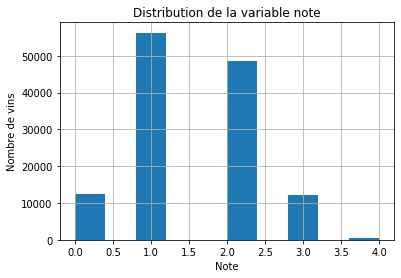

In [ ]:
data_stat['note'] = (data_stat['points']-data_stat['points'].min())//4.001
fig = data_stat['note'].hist()
plt.xlabel('Note')
plt.ylabel('Nombre de vins')
plt.title('Distribution de la variable note')
plt.show()

On retrouve ici une distribution non égalitaire, les notes 0 et surtout 4 sont très peu représentées. Dans la suite, cela pourra poser problème pour évaluer des très mauvais ou des très bon vins.

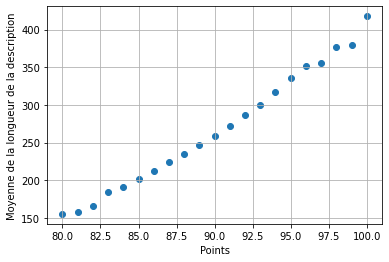

In [ ]:
data_stat['round_points'] = data_stat['points'].round()
liste_desc = np.array(data['description'])
liste_longueur_com = [len(com) for com in liste_desc]
data_stat['longueur_com'] = pd.Series(liste_longueur_com)
meanByPoint = data_stat.groupby(by='round_points').mean()
meanByNote = data_stat.groupby(by='note').mean()
## meanByPoint est une dataframe des moyennes des variables quantitatives après un regroupement par point##
## meanByNote est une dataframe des moyennes des variables quantitatives après un regroupement par note##
plt.scatter(meanByPoint.index,meanByPoint['longueur_com'])
plt.grid()
plt.xlabel('Points')
plt.ylabel('Moyenne de la longueur de la description')
plt.show()

Il est amusant de voir une certaine relation affine entre la longueur de la description et les points d'un vin.

##Etude de la variable 'price'
La variable 'price' représente le prix de chaque vin. Etudions sa distribution :

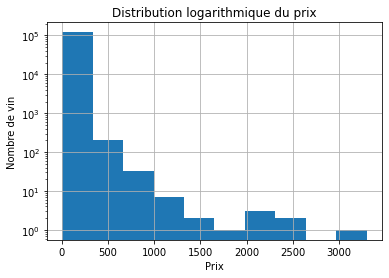

In [ ]:
fig = data_stat['price'].plot(kind='hist',logy=True)
plt.grid()
plt.xlabel('Prix')
plt.ylabel('Nombre de vins')
plt.title('Distribution logarithmique du prix')
plt.show()

On remarque imédiatement que la majorité des vins de notre base de donnée est comprise entre en dessous de 250€. Néanmoins, certaines valeurs peuvent attendre les 3000€. Certaines valeurs extrêmes pourraient être à enlever de notre modèle.

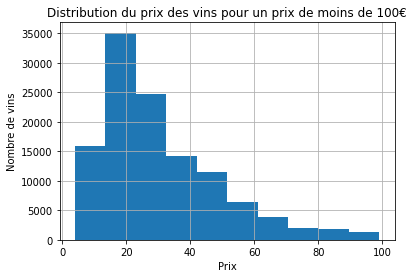

In [ ]:
fig = data_stat[data_stat['price']<100]['price'].hist()
plt.xlabel('Prix')
plt.ylabel('Nombre de vins')
plt.title('Distribution du prix des vins pour un prix de moins de 100€')
plt.show()

En détaillant la distribution pour des prix en dessous de 100€, on remarque que beaucoup des vins référencés dans notre base de données ont des prix compris entre 10 et 40€, ce qui correspond bien aux prix des vins que l'on peut trouver le plus.

##Etude croisée des variables
Nous allons dans cette partie nous intéresser à l'étude des variables 'points' et 'price' lorsque l'on s'intéresse aux deux en même temps.

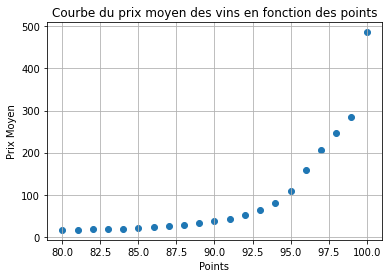

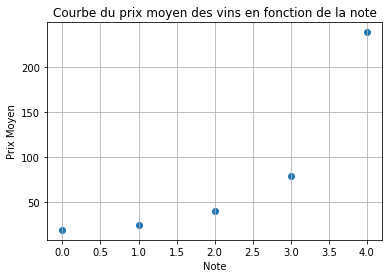

In [ ]:
plt.scatter(meanByPoint['points'],meanByPoint['price'])
plt.grid()
plt.xlabel('Points')
plt.ylabel('Prix Moyen')
plt.title('Courbe du prix moyen des vins en fonction des points')
plt.show()

plt.scatter(meanByNote.index,meanByNote['price'])
plt.grid()
plt.xlabel('Note')
plt.ylabel('Prix Moyen')
plt.title('Courbe du prix moyen des vins en fonction de la note')
plt.show()

In [ ]:
print('la corrélation entre le prix moyen et les points est de : '+str(meanByPoint['points'].corr(meanByPoint['price'])))

la corrélation entre le prix moyen et les points est de : 0.7965406000826235


On remarque, comme on peut s'y attendre, qu'il y a une corrélation forte entre le prix moyen par points et le nombre de points : plus le prix est élevé, plus les points sont proches de 100.

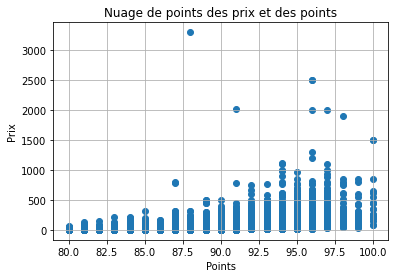

La corrélation entre le prix et les points est de : 0.4161667418606222


In [ ]:
plt.scatter(data_stat['points'],data_stat['price'])
plt.grid()
plt.xlabel('Points')
plt.ylabel('Prix')
plt.title('Nuage de points des prix et des points')
plt.show()
print('La corrélation entre le prix et les points est de : '+str(data_stat['points'].corr(data_stat['price'])))

Néanmoins, cette relation est à relativiser lorsque l'on s'intéresse à l'ensemble des prix de notre base de données. La corrélation entre les deux chute énormément. On peut d'ailleurs remarquer que le vin ayant le prix le plus élevé de notre base de données n'a que 88 points sur 100 !

##Etude des vins Français
Nous allons dans cette partie nous pencher un petit peu plus sur les vins français et les comparer avec les vins des autres pays. Voyons voir si la France mérite sa réputation concernant la qualité de son vin...

In [ ]:
data_stat[data_stat['country']=='France']['country'].count()

22093

Il y a donc 22093 vins français sur les 129908 qui composent notre base de données. Ce qui représente 17% de la base de données ! Elle même composée de 63 pays différents. La France est donc largement bien représentée dans cette base de données

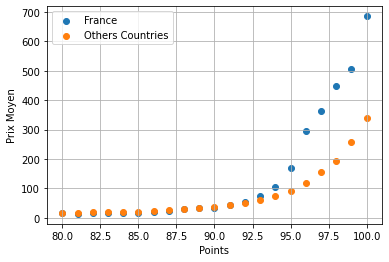

In [ ]:
data_stat_FR = data_stat[data_stat['country']=='France']
meanByPoint_FR = data_stat_FR.groupby(by='round_points').mean()
data_stat_others = data_stat[data_stat['country']!='France']
meanByPoint_others = data_stat_others.groupby(by='round_points').mean()

plt.scatter(meanByPoint.index,meanByPoint_FR['price'],label='France')
plt.scatter(meanByPoint.index,meanByPoint_others['price'],label='Others Countries')
plt.grid()
plt.legend()
plt.xlabel('Points')
plt.ylabel('Prix Moyen')
plt.show()

In [ ]:
En comparaison aux autres pays, pour des vins de bonne qualité, il faudra dépenser davantage en France. Alors que pour un vin de moins bonne qualité, le prix reste assez similaire.

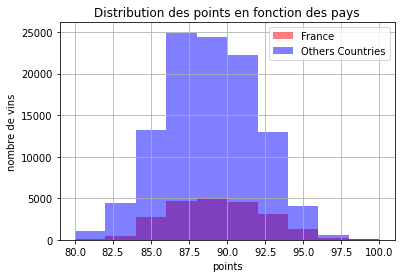

In [ ]:
fig1 = data_stat_FR['points'].hist(alpha=0.5,color='r',label='France')
fig2 = data_stat_others['points'].hist(alpha=0.5,color='b',label='Others Countries')
plt.legend()
plt.xlabel('points')
plt.ylabel('nombre de vins')
plt.title('Distribution des points en fonction des pays')
plt.show()

              France  Others   Pourcent
round_points                           
80                15     382   3.778338
81                36     656   5.202312
82               107    1728   5.831063
83               301    2723   9.953704
84              1088    5390  16.795307
85              1709    7820  17.934726
86              2024   10571  16.069869
87              2594   14333  15.324629
88              2898   14300  16.850797
89              2129   10079  17.439384
90              2538   12865  16.477310
91              2030    9323  17.880736
92              1710    7896  17.801374
93              1393    5096  21.467098
94               856    2902  22.778073
95               413    1122  26.905537
96               145     378  27.724665
97                70     159  30.567686
98                21      56  27.272727
99                 8      25  24.242424
100                8      11  42.105263


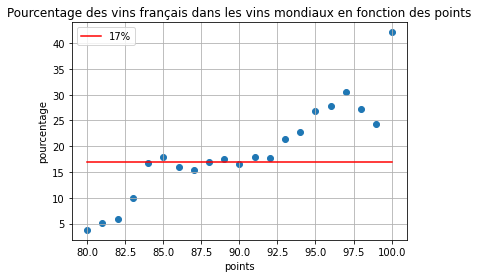

In [ ]:
data_compare = pd.DataFrame()
data_compare['France'] = data_stat_FR.groupby(by='round_points').count()['country']
data_compare['Others'] = data_stat_others.groupby(by='round_points').count()['country']
data_compare['Pourcent'] = data_compare['France']/(data_compare['France']+data_compare['Others'])*100
##Pourcent représente le pourcentage des vins français dans l'ensemble des vins de notre base de données à chaque point##
print(data_compare)

plt.scatter(data_compare.index,data_compare['Pourcent'])
plt.plot(list(data_compare.index),[17 for i in range(len(list(data_compare.index)))],color='r',label='17%')
plt.grid()
plt.legend()
plt.title('Pourcentage des vins français dans les vins mondiaux en fonction des points')
plt.xlabel('points')
plt.ylabel('pourcentage')
plt.show()

On a donc vu que les vins français représentes 17% de notre base de données. D'après l'étude précédente, on remarque que les vins français sont davantage compris dans les vins de bonne qualité que dans les vins ayant les moins bonnes notes.

# Prédiction de la classe du vin en fonction de sa description
Dans cette partie, nous allons chercher à déterminer la qualité, donc la note (cf. l'étude des stat. desc.) ou la classe, d'un vin en utilisant seulement sa description. Le prix n'est donc pas utilisé dans cette partie.
Pour rappel, nous séparons l'ensemble des points des vins en 5 classes.

## Premier modèle
Pour ce premier modèle, nous allons analyser la description du vin de cette manière :
1. Séparation de la phrase en une liste de mots
2. Vectorisation de chaque mot de la phrase
3. Calcul d'un vecteur "moyen" en faisant la moyenne des vecteurs de chaque mot

Ce modèle ne prend donc pas en compte l'ordre des mots. Mais permet de déterminer l'idée "moyenne" de la phrase.

In [ ]:
data_1 = data.sample(frac = 1, random_state = 1)
X = data_1['description']
Y = data_1['points']

### Séparation en 5 catégorie de vins

Le modèle que nous allons utiliser ici ne sera certainement pas suffisant pour déterminer avec exactitude la note du vin. C'est pourquoi, comme dans l'étude des statistiques descriptives, nous allons séparer en 5 catégories les notes :
- 0 : points entre 80 et 84
- 1 : points entre 84 et 88
- 2 : points entre 88 et 92
- 3 : points entre 92 et 96
- 4 : points entre 96 et 100

In [ ]:
# Creating the 5 classes, transform X, Y into array

Y = np.array(Y)
X = np.array(X)
mini = min(Y)
for idx in range(len(Y)):
    Y[idx] = abs(Y[idx] - mini)//4.001   

In [ ]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2)
Y_train = np.array(Y_train, dtype = int)

In [ ]:
def sentence_to_avg(sentence, word_to_vec_map):
 
    ''' 
    
    This function transform a sentence into a representative vector
    Arguments :
    sentence        -- str correspond to the critics of the wine
    word_to_vec_map --  give the vector associated to the word in GloVe doc
    Returns :
    avg -- vector of dim 50
    
     '''
    #Step 1: transform the str sentence into a list of words
    words = sentence.lower().split()

    # Initialize the average word vector
    avg = np.zeros(50)
    
    # Step 2: average the word vectors.
    total = 0
    for w in words:
        while w not in word_to_vec_map.keys():
            if w[1:] in word_to_vec_map.keys():
                w = w[1:]
            else:
                w = w[:-1]
        total += word_to_vec_map[w]
    avg = total/len(words)
    
    
    return avg

In [ ]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


def model(X, Y, word_to_vec_map, learning_rate = 0.01, num_iterations = 800):

    m = Y.shape[0]                          # number of training examples
    n_y = 5                                 # number of classes  
    n_h = 50                                # dimensions of the GloVe vectors 
    
    # Initialize parameters using Xavier initialization
    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros((n_y,)) 
    
    # Convert Y to Y_onehot with n_y classes
    Y_oh = convert_to_one_hot(Y) 
    
    # Optimization loop
    for t in range(num_iterations): 
        for i in range(m):          
            
            avg = sentence_to_avg(X[i], word_to_vec_map)
            z = np.dot(W,avg) + b
            a = softmax(z)

            cost = - np.dot(Y_oh[i],np.log(a))
            
            # Compute gradients 
            dz = a - Y_oh[i]
            dW = np.dot(dz.reshape(n_y,1), avg.reshape(1, n_h))
            db = dz

            # Update parameters with Stochastic Gradient Descent
            W = W - learning_rate * dW
            b = b - learning_rate * db
        
        if t % 100 == 0:
            print("Epoch: " + str(t) + " --- cost = " + str(cost))
            pred = predict(X, Y, W, b, word_to_vec_map)

    return pred, W, b

In [ ]:
def predict(X, Y, W, b, word_to_vec_map):
    """
    Arguments :
    X -- input data containing sentences, numpy array of shape (m, None)
    Y -- labels, numpy array of shape (m, 1)
    
    Returns:
    pred -- numpy array of shape (m, 1) with your predictions
    """
    m = X.shape[0]
    pred = np.zeros((m, 1))
    
    for j in range(m):                      
        
        # Split jth test example (sentence) into list of lower case words
        words = X[j].lower().split()
        
        # initialising avg
        avg = np.zeros((50,))
        for w in words:
          #Some problems occur with ".split()", sometimes we don't want the first or the last character.
          #Kind of the hard way to do it, but it works...
            while w not in word_to_vec_map.keys():
                if w[1:] in word_to_vec_map.keys():
                    w = w[1:]
                else:
                    w = w[:-1]
            avg += word_to_vec_map[w]
        avg = avg/len(words)

        # Forward propagation
        Z = np.dot(W, avg) + b
        A = softmax(Z)
        pred[j] = np.argmax(A)
        
    print("Accuracy: "  + str(np.mean((pred[:] == Y.reshape(Y.shape[0],1)[:]))))
    
    return pred

In [ ]:
#Training the model
pred, W, b = model(X_train, Y_train, word_to_vec_map,num_iterations=1)

Epoch: 0 --- cost = 0.6704963387015194
Accuracy: 0.5329402939139801


In [ ]:
print("Training set:")
pred_train = predict(X_train, Y_train, W, b, word_to_vec_map)
print('Test set:')
pred_test = predict(X_test, Y_test, W, b, word_to_vec_map)

Training set:
Accuracy: 0.5329402939139801
Test set:
Accuracy: 0.5341027120600116


On se retrouve avec une accuracy de 50%. Le hasard devrait nous donner 20% de réussite car on a 5 catégories, donc on a déjà mieux que le hasard. Néanmoins ce n'est pas exeptionnel.

In [ ]:
#A little test to see if it works...
X_my_sentences = np.array(["I love that wine, it is so tasteful. A great success to see in the future"])
Y_my_labels = np.array([[3]])
pred = predict(X_my_sentences, Y_my_labels , W, b, word_to_vec_map)
pred

Accuracy: 0.0


array([[2.]])

Vérifions à partir d'une matrice de confusion si les résultats sont pertinents

In [24]:
def plot_confusion_matrix(y_actu, y_pred, title='Confusion matrix', cmap=plt.cm.gray_r):
    
    df_confusion = pd.crosstab(y_actu, y_pred.reshape(y_pred.shape[0],), rownames=['Actual'], colnames=['Predicted'], margins=True)
    
    df_conf_norm = df_confusion / df_confusion.sum(axis=1)
    
    plt.matshow(df_confusion, cmap=cmap)

    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

Predicted  0.0  1.0   2.0  3.0   All
Actual                              
0           42  144    69    0   255
1           30  555   537    1  1123
2            5  192   765    6   968
3            0    9   235    5   249
4            0    0     5    0     5
All         77  900  1611   12  2600


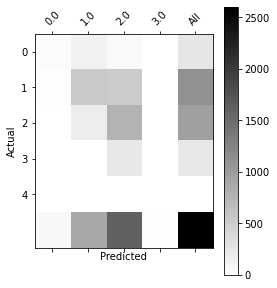

In [ ]:
print(pd.crosstab(Y_test, pred_test.reshape(Y_test.shape), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, pred_test)

La matrice de confusion montre que ce modèle n'est vraiment pas précis. Le modèle prédit aucune note de 4. Si on se réfère à l'histogramme de l'étude des statistiques descriptives, cela peut s'expliquer par le peu de vins ayant une très mauvaise et surtout une très bonne note. Il faudrait donc revoir notre séparation des notes en 5 catégories. C'est ce que nous allons faire dans la suite.

### Séparation en 5 catégorie à partir des quantiles
Notre distribution étant proche d'une loi normale et non une loi uniforme, nous allons séparer les classes en fonction des quantiles (20% pour chaque classe).
On obtient donc comme note :
- 0 si la note du vin fait partie des 20% des pires notes
- 1 si la note est entre les 20% et 40%
- 2 si la note est entre les 40% et 60%
- 3 si la note est entre les 60% et 80%
- 4 si la note est dans les 20% meilleures notes

In [ ]:
data_12 = data.sample(frac = 1, random_state = 1)
X = data_12['description']
Y = data_12['points']
quant = Y.quantile([0.2,0.4,0.6,0.8,1])
print(quant)

0.2     86.0
0.4     88.0
0.6     89.0
0.8     91.0
1.0    100.0
Name: points, dtype: float64


On remarque alors que les notes correspondent à :
- 0 si les points sont entre 80 et 86 (très mauvais vins)
- 1 si les points sont entre 86 et 88 (mauvais vins)
- 2 si les points sont entre 88 et 89 (vins normaux)
- 3 si les points sont entre 89 et 91 (bon vins)
- 4 si les points sont entre 91 et 100 (très bon vins)

In [ ]:
#This is the only difference with model 1.1: approximatively 20% of the values are in each classes
#Note that it is possible to optimize the running time by using vectorial calcul and mask 
Y = np.array(Y)
for idx in range(len(Y)):
    if Y[idx] <= quant[0.2] and np.sum(Y ==0) < len(Y)/5:
        Y[idx] = 0
    elif Y[idx] <= quant[0.4] and np.sum(Y ==0) < len(Y)/5:
        Y[idx] = 1
    elif Y[idx] <= quant[0.6] and np.sum(Y ==0) < len(Y)/5:
        Y[idx] = 2
    elif Y[idx] <= quant[0.8] and np.sum(Y ==0) < len(Y)/5:
        Y[idx] = 3
    else:
        Y[idx] = 4

In [ ]:
#Split the set in train/test
X = np.array(X)
Y = np.array(Y, dtype=int)
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2)


In [ ]:
#train the model
pred, W_1, b_1 = model(X_train, Y_train, word_to_vec_map,num_iterations=1)

Epoch: 0 --- cost = 0.6080120168378093
Accuracy: 0.4057282449796107


In [ ]:
print("Training set:")
pred_train = predict(X_train, Y_train, W_1, b_1, word_to_vec_map)
print('Test set:')
pred_test = predict(X_test, Y_test, W_1, b_1, word_to_vec_map)


Training set:
Accuracy: 0.3969954604908825
Test set:
Accuracy: 0.3989613387189844


Predicted   0.0   1.0  3.0    4.0    All
Actual                                  
0           295   238    5   4609   5147
1           305   245    1   4596   5147
2           114    88    1   1640   1843
3           228   171    1   3574   3974
4           651   449    0   8784   9884
All        1593  1191    8  23203  25995


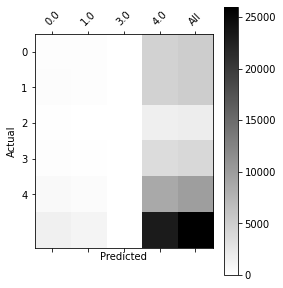

In [ ]:
print(pd.crosstab(Y_test, pred_test.reshape(Y_test.shape), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, pred_test)

L'accuracy diminue et la matrice de confusion est loin d'être parfaite. Ce modèle ne semble donc pas être suffisant afin de répondre à notre problèmatique.
Nous allons donc nous intéresser à un nouveau modèle : le modèle LSTM.

## Modèle LSTM

Le modèle LSTM permet de prendre en compte l'ordre des mots, et donc d'analyser l'ensemble de la description. Ce modèle interprète la phrase entière.

In [11]:
import numpy as np
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform

L'une des différences majeures entre ce modèle et le premier, c'est que l'on s'intéresse ici à la longueur de la description. Nous allons donc éliminer de notre base de données les descriptions qui sont trop longues.

In [12]:
data_3 = data.sample(frac = 0.3, random_state = 1)
data_3= data_3.sort_values(by=['points'])
X_LTSM = data_3['description']
Y = data_3['points']

quant = Y.quantile([0.2,0.4,0.6,0.8,1])

X_LTSM = np.array(X_LTSM)
Y = np.array(Y)

#Here we check the size of each X
size =[]
for i in range(len(X_LTSM)):
  size.append(len(X_LTSM[i].split()))
size = np.array(size)

#In order to mask the ones that are too long (here the 1% the longest)
mask = pd.Series(size)< np.quantile(size,0.99)

X_LTSM = X_LTSM[mask]
Y = Y[mask] 


for idx in range(len(Y)):
    if Y[idx] <= quant[0.2] and np.sum(Y ==0) < len(Y)/5:
        Y[idx] = 0
    elif Y[idx] <= quant[0.4] and np.sum(Y == 1) < len(Y)/5:
        Y[idx] = 1
    elif Y[idx] <= quant[0.6] and np.sum(Y == 2) < len(Y)/5:
        Y[idx] = 2
    elif Y[idx] <= quant[0.8] and np.sum(Y == 3) < len(Y)/5:
        Y[idx] = 3
    else:
        Y[idx] = 4


In [13]:
size = size[mask]
size.max()

70

La taille maximale des descriptions est donc de 70, les descriptions plus longues ont été éliminé. Les descriptions plus courtes vont donc être complétées par des blancs afin d'atteindre la taille maximale, ce qui est nécessaire à l'utilisation de notre modèle.

In [14]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (str) into an array of indices corresponding to words in the sentences.
    
    Arguments:
    X -- array of sentences of shape (m, 1)
    word_to_index -- a dictionary containing each word mapped to its index
    max_len -- maximum number of words in a sentence. Here worth size.max() 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]                                   # number of training examples
    
    X_indices = np.zeros((m, max_len))
    
    for i in range(m):                               # loop over training examples
        
        sentence_words = X[i].lower().split()
        
        j = 0
        
        # Loop over the words of sentence_words
        for w in sentence_words:
          #Same thing than in Modèle 1.1
          while w not in word_to_vec_map.keys():
                if w[1:] in word_to_vec_map.keys():
                    w = w[1:]
                else:
                    w = w[:-1]
          X_indices[i, j] = word_to_index[w]
          j += 1
            
    
    return X_indices

In [15]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """

    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 1                 
    
    emb_dim = word_to_vec_map["cucumber"].shape[0] 
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]
    embedding_layer = Embedding(vocab_len, emb_dim, trainable = True)

    embedding_layer.build((None,)) 
    
    # Set the weights of the embedding layer to the embedding matrix.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [16]:
def Wine_model(input_shape, word_to_vec_map, word_to_index):
    """
    LSTM Model and its differents layers
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map
    word_to_index 

    Returns:
    model -- a model instance in Keras
    """
    
    # Define Input layer
    sentence_indices = Input(input_shape, dtype= 'int32')
    
    # Create the embedding layer pretrained with GloVe Vectors
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer
    embeddings = embedding_layer(sentence_indices)
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    X = LSTM(128, return_sequences=True)(embeddings)
    X = Dropout(0.5)(X)

    X = LSTM(128, return_sequences=False)(X)
    X = Dropout(0.5)(X)

    X = Dense( units = 5)(X)
    X = Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X
    model = Model(inputs=sentence_indices, outputs=X)
    
    return model

In [17]:
model = Wine_model((size.max(),), word_to_vec_map, word_to_index)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 70)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 70, 50)            20000000  
_________________________________________________________________
lstm (LSTM)                  (None, 70, 128)           91648     
_________________________________________________________________
dropout (Dropout)            (None, 70, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                

In [18]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
#Split into train/test sets
Y = np.array(Y, dtype=int)
X_train,X_test,Y_train,Y_test = train_test_split(X_LTSM,Y,test_size=0.2)

In [20]:
#Convert X and Y to fit the model size:
X_train_indices = sentences_to_indices(X_train, word_to_index, size.max())
Y_train_oh = convert_to_one_hot(Y_train)

In [21]:
model.fit(X_train_indices, Y_train_oh, epochs = 10, batch_size = 1500, shuffle=True)

Epoch 1/10
21/21 [==============================] - 5s 252ms/step - loss: 1.5304 - accuracy: 0.2971
Epoch 2/10
21/21 [==============================] - 5s 248ms/step - loss: 1.4436 - accuracy: 0.3460
Epoch 3/10
21/21 [==============================] - 5s 247ms/step - loss: 1.3339 - accuracy: 0.3963
Epoch 4/10
21/21 [==============================] - 5s 244ms/step - loss: 1.2626 - accuracy: 0.4313
Epoch 5/10
21/21 [==============================] - 5s 244ms/step - loss: 1.2102 - accuracy: 0.4572
Epoch 6/10
21/21 [==============================] - 5s 245ms/step - loss: 1.1620 - accuracy: 0.4783
Epoch 7/10
21/21 [==============================] - 5s 245ms/step - loss: 1.1352 - accuracy: 0.4919
Epoch 8/10
21/21 [==============================] - 5s 248ms/step - loss: 1.0994 - accuracy: 0.5079
Epoch 9/10
21/21 [==============================] - 5s 238ms/step - loss: 1.0742 - accuracy: 0.5212
Epoch 10/10
21/21 [==============================] - 5s 245ms/step - loss: 1.0469 - accuracy: 0.5354

In [22]:
#Test:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = size.max())
Y_test_oh = convert_to_one_hot(Y_test)
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
pred = model.predict(X_test_indices)
pred = np.argmax(pred, axis = 1) 
print()
print("Test accuracy = ", acc)

242/242 [==============================] - 1s 6ms/step - loss: 1.1360 - accuracy: 0.4894

Test accuracy =  0.4894416332244873


Predicted     0     1     2     3     4   All
Actual                                       
0           933   466   120    19     1  1539
1           322   715   407   101     9  1554
2            86   456   646   305    80  1573
3            12   130   458   626   339  1565
4             1    29   144   456   858  1488
All        1354  1796  1775  1507  1287  7719


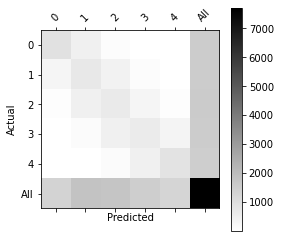

In [25]:
print(pd.crosstab(Y_test, pred.reshape(Y_test.shape), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, pred)

On a ici une accuracy correct, mais surtout, la matrice de confusion semble bien meilleure que celles qu'on pouvait avoir avec le premier modèle.

On peut donc se demander s'il est possible de directement prédire la note sur 100 et non pas de déterminer dans quelle classe sur les 5 notre vin est.
Nous allons donc dans la suite essayer de déterminer directement la note.

 # Prédiction des points du vin en fonction de sa description
 Nous allons donc, dans cette partie, ne plus séparer les vins en 5 classes, mais essayer de déterminer directement leurs points sur 100.

## Premier modèle avec description et prix en input
Nous réutilisons le premier modèle, qui détermine une "moyenne" sur l'ensemble des mots de la description.
De plus, on ajoute en input le prix. On obtient donc en input la "moyenne" sur les mots de la description et le prix du vin.

In [ ]:
#A new sentence_to_avg must be defined because we have to had prices in the X values.

def sentence_to_avg(sentence, word_to_vec_map):
 
    words = sentence.lower().split()

    # Initialize the average word vector
    avg = np.zeros(50)
    
    # Step 2: average the word vectors. 
    total = 0
    for w in words:
        while w not in word_to_vec_map.keys():
            if w[1:] in word_to_vec_map.keys():
                w = w[1:]
            else:
                w = w[:-1]
        total += word_to_vec_map[w]
    avg = total/len(words)
    
    
    return avg

In [ ]:
data_4 = data[['description', 'points', 'price', 'taster_name']].sample(frac = 1, random_state = 1)
data_4 = data_4.dropna()
X = data_4['description']
Y = data_4['points']
prices = data_4['price']

Y = np.array(Y)
m=len(X)

#Some preprocessing on X...

X = np.array(X)
X_emb = np.zeros((m,50)) 
prices = np.array(prices)
prices = np.log(prices)
prices = prices - prices.mean()
for i in range(m): 
  X_emb[i] = sentence_to_avg(X[i], word_to_vec_map)
X_emb = np.column_stack((X_emb,prices))

Y = np.array(Y, dtype=int)
X_train,X_test,Y_train,Y_test=train_test_split(X_emb,Y,test_size=0.2)

In [ ]:
def relu(x):
    if x <0:
        x = 0
    return x

In [ ]:
def model_4(X, Y, word_to_vec_map, learning_rate = 0.01, num_iterations = 400):

    m = Y.shape[0]                          # number of training examples
    n_y = 1                                 # number of classes  
    n_h = 51                               # dimensions of the GloVe vectors + 1 (for price)
    
    # Initialize parameters using Xavier initialization
    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros((n_y,)) 
    
    
    # Optimization loop
    for t in range(num_iterations): # Loop over the number of iterations
        for i in range(m):          # Loop over the training examples
          
            # Forward propagate the avg through the softmax layer
            z = np.dot(W,X[i]) + b
            a = relu(z)
            
            # Compute gradients 
            dz = a - Y[i]
            dW = np.dot(dz.reshape(n_y,1), X[i].reshape(1, n_h))
            db = dz

            # Update parameters with Stochastic Gradient Descent
            W = W - learning_rate * dW
            b = b - learning_rate * db
        
        if t % 100 == 0:
            print("Epoch: " + str(t))
            pred = predict_4(X, Y, W, b, word_to_vec_map)

    return pred, W, b

In [ ]:
def predict_4(X, Y, W, b, word_to_vec_map):
    """
    Arguments:
    X -- input data containing avg and prices, numpy array of shape (m, 51)
    Y -- labels, numpy array of shape (m, 1)
    
    Returns:
    pred -- numpy array of shape (m, 1) with your predictions
    """
    m = X.shape[0]
    pred = np.zeros(m)
    
    for j in range(m):                       # Loop over training examples
        
        # Forward propagation
        Z = np.dot(W, X[j]) + b
        A = relu(Z)
        pred[j] = A[0]
        
    print("Loss (=mse): "  + str(np.square(np.subtract(Y,pred)).mean() ))
    
    return pred

In [ ]:
pred, W_4, b_4 = model_4(X_train, Y_train, word_to_vec_map)
print(pred)

Epoch: 0
Loss (=mse): 5.182880803811053
Epoch: 100
Loss (=mse): 4.617114757838115
Epoch: 200
Loss (=mse): 4.612288578099743
Epoch: 300
Loss (=mse): 4.6118770235566595
[89.00637062 87.32427113 88.04177693 ... 86.62986217 87.51531038
 89.20388484]


In [ ]:
print("Training set:")
pred_train = predict_4(X_train, Y_train, W_4, b_4, word_to_vec_map)
print('Test set:')
pred_test = predict_4(X_test, Y_test, W_4, b_4, word_to_vec_map)

Training set:
Loss (=mse): 4.611837106977011
Test set:
Loss (=mse): 4.646770628559942


In [ ]:
#Let's try to analyse our prediction:
ecart = []
for i in range(0,len(Y_test)):
 ecart.append(abs(pred_test[i] - Y_test[i]))
ecart = np.array(ecart)
print("ecart max:" +str(np.max(ecart)))
print("ecart moy:"+ str(ecart.mean()))
print("variance de l'écart:" + str(ecart.var()))
print(np.quantile(ecart, 0.9))

ecart max:10.568191636745027
ecart moy:1.721297912202558
variance de l'écart:1.6839041260070562
3.5374129820870692


Avec ce modèle, on obtient un écart moyen de 1,72 points, ce qui est correct même si loin d'être parfait. On remarque néanmoins que cela semble être plus précis que les classes créées dans la partie précédente, car les classes regroupées des notes séparées de 4 points.
Nous allons d'ailleurs voir si on peut comparer ce modèle avec celui de la partie précédente :

Predicted   0.0   1.0   2.0   3.0   4.0    All
Actual                                        
0           934   900   913   902   919   4568
1          1020  1031  1037  1034   979   5101
2           409   425   408   392   378   2012
3           827   805   835   865   889   4221
4           670   698   666   666   694   3394
All        3860  3859  3859  3859  3859  19296


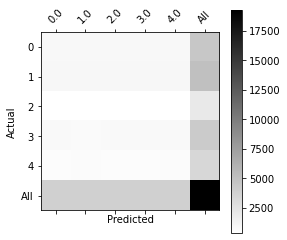

In [ ]:
#Si on veut comparer aux modèles précédents:

Y_test = pd.Series(Y_test)
quant = Y_test.quantile([0.2,0.4,0.6,0.8,1])
Y_res = np.array(Y_test)

for idx in range(len(Y_test)):
    if Y_res[idx] <= quant[0.2]:
        Y_res[idx] = 0
    elif Y_res[idx] <= quant[0.4]:
        Y_res[idx] = 1
    elif Y_res[idx] <= quant[0.6]:
        Y_res[idx] = 2
    elif Y_res[idx] <= quant[0.8]:
        Y_res[idx] = 3
    else:
        Y_res[idx] = 4

pred_test= pd.Series(pred_test)
quant_pred = pred_test.quantile([0.2,0.4,0.6,0.8,1])
pred_res = np.array(pred_test)

for idx in range(len(Y_test)):
    if pred_res[idx] <= quant_pred[0.2]:
        pred_res[idx] = 0
    elif pred_res[idx] <= quant_pred[0.4]:
        pred_res[idx] = 1
    elif pred_res[idx] <= quant_pred[0.6]:
        pred_res[idx] = 2
    elif pred_res[idx] <= quant_pred[0.8]:
        pred_res[idx] = 3
    else:
        pred_res[idx] = 4

print(pd.crosstab(Y_res, pred_res.reshape(Y_test.shape), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_res, pred_res)


Pour comparer avec la partie précédente, on classifie les prédictions réalisées avec ce modèle. Cette classification se fait avec les quantiles.
On obtient alors une matrice de confusion bien plus satisfaisante que la matrice de confusion réalisée dans la partie 1.1.2

In [ ]:
str('Accuracy: ' + str(np.mean(pred_res[:] == Y_res[:]) ) )

'Accuracy: 0.20377280265339967'

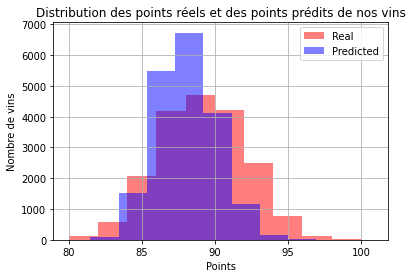

In [ ]:
#Here the distribution can also give us some hints of the quality of the prediction
fig1 = Y_test.hist(alpha = 0.5, color = 'r',label='Real')
fig2 = pred_test.hist(alpha = 0.5, color = 'b',label='Predicted')
plt.legend()
plt.xlabel('Points')
plt.ylabel('Nombre de vins')
plt.title('Distribution des points réels et des points prédits de nos vins')
plt.show()

Lorsque l'on compare la distribution des points prédits des vins avec celle des points réels, on observe que notre modèle a tendance à prédire un nombre de points inférieur au vrai points de notre vin.

## Modèle LSTM avec description en input
Nous revenons au modèle LSTM. Nous ne prendrons pas le prix en input dans cette partie. Par contre, notre objectif est toujours de déterminer les points de notre vin et non sa classe.

In [147]:
import numpy as np
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform

In [148]:
data_5 = data.sample(frac = 1, random_state = 1)
data_5= data_5.sort_values(by=['points'])
X_LTSM = data_5['description']
Y_LTSM = data_5['points']

print(len(X_LTSM))
X_LTSM = np.array(X_LTSM)

size =[]
for i in range(len(X_LTSM)):
  size.append(len(X_LTSM[i].split()))
size = np.array(size)

mask = pd.Series(size) <= np.quantile(size,0.99)
X_LTSM = np.array(X_LTSM)
Y_LTSM = np.array(Y_LTSM)

X_LTSM = X_LTSM[mask]
Y_LTSM = Y_LTSM[mask] 
size = size[mask] 

#Preprocessing of the Y values:
min_Y = Y_LTSM.min()
max_Y = Y_LTSM.max()
Y_LTSM = (Y_LTSM - min_Y)/(max_Y - min_Y)

size.max()

129971


71

In [149]:
#Split train/test

X_train,X_test,Y_train,Y_test = train_test_split(X_LTSM,Y_LTSM,test_size=0.2)
X_train_indices = sentences_to_indices(X_train, word_to_index, size.max())

In [150]:
def Wine_model_2(input_shape, word_to_vec_map, word_to_index):
    """
    Arguments:
    input_shape -- shape of the input, here size.max()
    word_to_vec_map
    word_to_index 

    Returns:
    model -- model instance in Keras
    """
    
    sentence_indices = Input(input_shape, dtype= 'int32')
    
    # Create the embedding layer pretrained with GloVe Vectors
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer
    embeddings = embedding_layer(sentence_indices)
    
    X = LSTM(128, return_sequences= True)(embeddings)
    X = Dropout(0.5)(X)
    
    X = LSTM(128, return_sequences= False)(X)
    X = Dropout(0.5)(X)
    
    #We just had a new 128 Dense Layer (because it works better...)
    X = Dense ( units = 128 )(X)
    X = Activation('relu')(X)
    X = Dropout(0.5)(X)

    X = Dense( units = 1 )(X)
    X = Activation('linear')(X)
    
    model = Model(inputs=sentence_indices, outputs=X)
    
    return model

In [151]:
model_2 = Wine_model_2((size.max(),), word_to_vec_map, word_to_index)
model_2.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 71)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 71, 50)            20000000  
_________________________________________________________________
lstm_6 (LSTM)                (None, 71, 128)           91648     
_________________________________________________________________
dropout_8 (Dropout)          (None, 71, 128)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)              

In [152]:
# Compute that to load a model : 

from keras.models import model_from_json
from keras.models import load_model


json_file = open('/content/drive/My Drive/Wine_project/final_p5.json', 'r')
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)
# load weights into new model
model_2.load_weights("/content/drive/My Drive/Wine_project/final_p5.hdf5")
print("Loaded model from disk")
model_2.save('/content/drive/My Drive/Wine_project/final_p5.hdf5')
model_2=load_model('/content/drive/My Drive/Wine_project/final_p5.hdf5')
from keras import metrics
model_2.compile(optimizer = 'adam', loss= 'mean_squared_error', metrics= [metrics.mean_squared_error, metrics.mean_absolute_error]) 


Loaded model from disk


In [153]:
from keras import metrics
model_2.compile(loss='mean_squared_error', optimizer='adam', metrics= [metrics.mean_squared_error, 
                       metrics.mean_absolute_error])

In [154]:
model_2.fit(X_train_indices, Y_train, epochs = 3, batch_size = 1500, shuffle=True)

Epoch 1/3
69/69 [==============================] - 17s 253ms/step - loss: 0.0136 - mean_squared_error: 0.0136 - mean_absolute_error: 0.0907
Epoch 2/3
69/69 [==============================] - 17s 248ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0636
Epoch 3/3
69/69 [==============================] - 17s 248ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0620


In [155]:
X_test_indices = sentences_to_indices(X_test, word_to_index, size.max())
loss, mse, mae = model_2.evaluate(X_test_indices, Y_test)
pred = model_2.predict(X_test_indices)

805/805 [==============================] - 4s 5ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0580


In [156]:
from keras.models import model_from_json
from keras.models import load_model
model_json = model_2.to_json()
with open("/content/drive/My Drive/Wine_project/final_p5.json", "w") as json_file:
  json_file.write(model_json)
model_2.save_weights("/content/drive/My Drive/Wine_project/final_p5.hdf5")

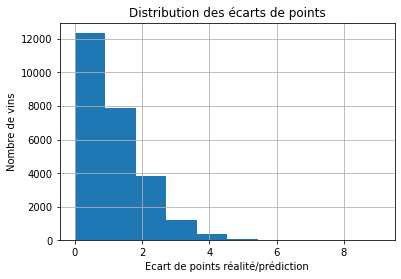

In [157]:
pred_post,Y_test_post = pred*(max_Y - min_Y) + min_Y,Y_test*(max_Y - min_Y) + min_Y
pred_post = np.reshape(pred_post,(len(pred)))
ecart = abs(pred_post - Y_test_post)
pd.Series(ecart).hist()
plt.xlabel('Ecart de points réalité/prédiction')
plt.ylabel('Nombre de vins')
plt.title('Distribution des écarts de points')
plt.show()

On remarque qu'une grande partie des écart de points réalité/prédiction est comprise entre 0 et 2, ce qui est assez correct.

In [158]:
np.quantile(ecart, 0.90)

2.4189208984375004

In [159]:
#petit test aléatoire:
i = rd.randint(0,len(pred_post))
print("Prédiction:" + str(pred_post[i]))
print("Réel :" +str(Y_test_post[i]))

Prédiction:85.94223
Réel :86.0


En fonction de ce petit test aléatoire, on remarque que l'écart entre la prédiction et la réalité est assez faible. Si on repète plusieurs fois le test, l'écart est notamment très faible pour des points compris dans la masse (entre 86 et 92), alors qu'il est plus grand si les points du vin sont soit très proche de 80, soit de 100.

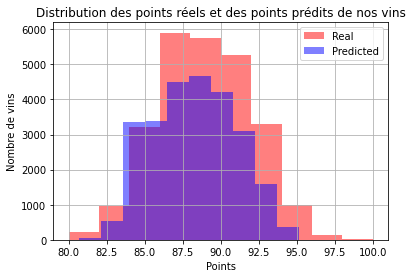

In [160]:
fig1 = pd.Series(Y_test_post).hist(alpha = 0.5, color = 'r',label='Real')
fig2 = pd.Series(pred_post).hist(alpha = 0.5, color = 'b',label='Predicted')
plt.xlabel('Points')
plt.ylabel('Nombre de vins')
plt.title('Distribution des points réels et des points prédits de nos vins')
plt.legend()
plt.show()

Si on compare ces distributions avec celles du premier modèle de la partie précédente, on remarque que ce modèle semble plus près de la réalité. Notamment, on a pas cet effet de sous estimation des points comme dans le premier modèle.

In [161]:
def predict_wine_score(sentence):
  #sentence MUST BE a string, it is the sentence describing the wine 
  #return the score (out of 100) predicted for the bottle described
  sentence = np.array([sentence])
  sentence = sentences_to_indices(sentence,word_to_index, size.max())
  return model_2.predict(sentence)[0][0]*(max_Y - min_Y) + min_Y

In [43]:
#Petit exemple avec ce vin 
#https://www.vivino.com/FR/fr/sainte-marguerite-symphonie-cotes-de-provence-rouge/w/3496774?year=2018&price_id=22596529&cart_item_source=nav-explore
#noté 4.3/5 ce qui équivaut à 86/100

predict_wine_score("After the white, the red. Wine with a nice roundness, a nice spicy and fleshy side. It is powerful and subtle at the same time. It's organic and it's all good. One of my reference domains in Côtes de Provence.")

86.17717802524567

Ce petit test nous permet de rendre compte de la précision de notre modèle.

Ce modèle semble être le modèle le plus complet. Il prédit assez précisemment les points d'un vin. Notamment sur des vins ayant des points entre 86 et 92.

Maintenant que l'on a une bonne prédiction de la qualité d'un vin à partir de sa description, nous pouvons essayé de déterminer le prix d'un vin à partir de sa description.

# Prediction du prix des vins

Dans cette partie, nous allons donc essayer de déterminer le prix d'un vin à partir de sa description. Nous réutilisons le modèle LSTM et mettons de côté la note du vin.

Comme on a pu le voir dans l'étude des statistiques descriptives, certains vins de notre base de données ont des prix exessifs, nous allons donc supprimer les 1% des prix les plus élevés de notre base de données afin d'avoir un meilleur modèle. 

129970


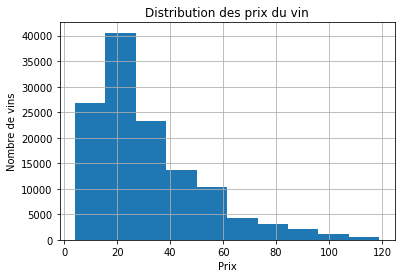

70

In [120]:

data_51 = data.sample(frac = 1, random_state = 1)
X_LTSM = data_51['description']
Y_LTSM = data_51['price']
Y_LTSM = Y_LTSM.fillna(method='backfill')

mask = Y_LTSM.isnull() <1
Y_LTSM = Y_LTSM[mask]
X_LTSM = X_LTSM[mask]
print(len(X_LTSM))

mask1 = Y_LTSM < np.quantile(np.array(Y_LTSM),0.98)

X_LTSM = np.array(X_LTSM)
Y_LTSM = np.array(Y_LTSM)
X_LTSM = X_LTSM[mask1]
Y_LTSM = Y_LTSM[mask1]

size =[]
for i in range(len(X_LTSM)):
  size.append(len(X_LTSM[i].split()))
size = np.array(size)

mask2 = pd.Series(size) <= np.quantile(size,0.99)

X_LTSM = X_LTSM[mask2]
Y_LTSM = Y_LTSM[mask2] 

pd.Series(Y_LTSM).hist()
plt.xlabel('Prix')
plt.ylabel('Nombre de vins')
plt.title('Distribution des prix du vin')
plt.show()

min_Y = Y_LTSM.min()
max_Y = Y_LTSM.max()
Y_LTSM = (Y_LTSM - min_Y)/(max_Y - min_Y)
size = size[mask2]
size.max()


In [121]:
#Split train/test

X_train,X_test,Y_train,Y_test=train_test_split(X_LTSM,Y_LTSM,test_size=0.2)
X_train_indices = sentences_to_indices(X_train, word_to_index, size.max())

In [122]:
# Compute that to load a model : 

from keras.models import model_from_json
from keras.models import load_model


json_file = open('/content/drive/My Drive/Wine_project/final_p5price.json', 'r')
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)
# load weights into new model
model_2.load_weights("/content/drive/My Drive/Wine_project/final_p5price.hdf5")
print("Loaded model from disk")
model_2.save('/content/drive/My Drive/Wine_project/final_p5price.hdf5')
model_2=load_model('/content/drive/My Drive/Wine_project/final_p5price.hdf5')
model_2.compile(optimizer = 'adam', loss= 'mean_squared_error', metrics= [metrics.mean_squared_error, metrics.mean_absolute_error]) 

from keras import metrics
model_2.compile(loss='mean_squared_error', optimizer='adam', metrics= [metrics.mean_squared_error, 
                       metrics.mean_absolute_error])


Loaded model from disk


In [123]:
#Do not run it if you have already load a model
model_2 = Wine_model_2((size.max(),), word_to_vec_map, word_to_index)
model_2.compile(loss='mean_squared_error', optimizer='adam', metrics= [metrics.mean_squared_error, 
                       metrics.mean_absolute_error])
model_2.fit(X_train_indices, Y_train, epochs = 15, batch_size = 1500, shuffle=True)

Epoch 1/15
68/68 [==============================] - 18s 269ms/step - loss: 0.0335 - mean_squared_error: 0.0335 - mean_absolute_error: 0.1354
Epoch 2/15
68/68 [==============================] - 17s 257ms/step - loss: 0.0255 - mean_squared_error: 0.0255 - mean_absolute_error: 0.1174
Epoch 3/15
68/68 [==============================] - 17s 255ms/step - loss: 0.0231 - mean_squared_error: 0.0231 - mean_absolute_error: 0.1103
Epoch 4/15
68/68 [==============================] - 17s 257ms/step - loss: 0.0214 - mean_squared_error: 0.0214 - mean_absolute_error: 0.1052
Epoch 5/15
68/68 [==============================] - 17s 256ms/step - loss: 0.0205 - mean_squared_error: 0.0205 - mean_absolute_error: 0.1026
Epoch 6/15
68/68 [==============================] - 17s 257ms/step - loss: 0.0195 - mean_squared_error: 0.0195 - mean_absolute_error: 0.0998
Epoch 7/15
68/68 [==============================] - 18s 259ms/step - loss: 0.0186 - mean_squared_error: 0.0186 - mean_absolute_error: 0.0973
Epoch 8/15
68

if an error pop up, make sure that you haave run all the required function to define model_2

In [124]:
from keras.models import model_from_json
from keras.models import load_model
model_json = model_2.to_json()
with open("/content/drive/My Drive/Wine_project/final_p5price.json", "w") as json_file:
  json_file.write(model_json)
model_2.save_weights("/content/drive/My Drive/Wine_project/final_p5price.hdf5")

In [125]:
X_test_indices = sentences_to_indices(X_test, word_to_index, size.max())
loss, mse, mae = model_2.evaluate(X_test_indices, Y_test)
pred = model_2.predict(X_test_indices)

787/787 [==============================] - 4s 6ms/step - loss: 0.0204 - mean_squared_error: 0.0204 - mean_absolute_error: 0.1021


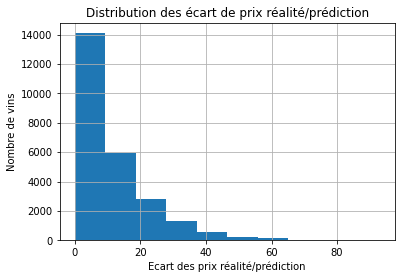

13.805211448669432

In [126]:
pred_post,Y_test_post = pred*(max_Y - min_Y) + min_Y, Y_test*(max_Y - min_Y) + min_Y
pred_post = np.reshape(pred_post,(len(pred)))
ecart = abs(pred_post - Y_test_post)
pd.Series(ecart).hist()
plt.xlabel('Ecart des prix réalité/prédiction')
plt.ylabel('Nombre de vins')
plt.title('Distribution des écart de prix réalité/prédiction')
plt.show()
np.quantile(ecart, 0.7)

La distribution des écarts prix/réalité montre que la plupart des prédictions réalisées ont un écart compris entre 0€ et 20€ de leur prix réel. Ce qui est pas terrible.

In [127]:
#petit test aléatoire:
i = rd.randint(0,len(pred_post))
print("Prédiction:" + str(pred_post[i]))
print("Réel :" +str(Y_test_post[i]))

Prédiction:23.004261
Réel :35.0


En faisant plusieurs fois ce petit test, on remarque que parfois le prix est bien prédit, alors qu'à d'autre moment on a un énorme écart entre la réalité et la prédiction. Cela ne semble pas dépendre du prix du vin initialement.

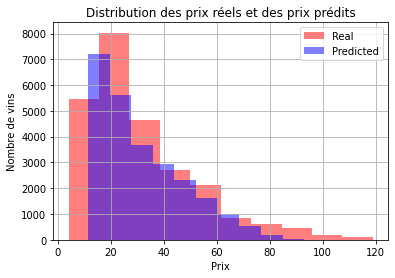

In [128]:
fig1 = pd.Series(Y_test_post).hist(alpha = 0.5, color = 'r',label='Real')
fig2 = pd.Series(pred_post).hist(alpha = 0.5, color = 'b',label='Predicted')
plt.xlabel('Prix')
plt.ylabel('Nombre de vins')
plt.title('Distribution des prix réels et des prix prédits')
plt.legend()
plt.show()

On remarque un écart dans les distributions des prix réels et des prix prédits. Notamment lorsque le prix est trop petit : le modèle sur-estime le prix.

Le modèle ne semble pas permettre de déterminer le prix à partir de la description.

#Application à la base de données secondaire
Nous allons maintenant appliquer le modèle LSTM à notre base de données secondaire afin de voir les résultats qui peuvent s'en dégager.

/!\ Pour que cette partie fonctionne, il faut faire tourner au préalable le modèle de la partie "Modèle LSTM avec description en input".
Si entre temps vous avez fait tourner la partie "prédiction du prix des vins", merci de bien vouloir refaire tourner la partie "Modèle LSTM avec description en input".

In [129]:
data_annexe2 = data_annexe.copy()
data_annexe2.head()

,nom,prix,avis
0,2019 CABERNET SAUVIGNON Camina,8.5,"A real gentle soul this, a subtle leafiness, t..."
1,2019 CAMINA Tempranillo,8.5,Juicy cranberry and redcurrant fruits on the n...
2,2018 MERLOT-CABERNET-CARIGNAN Domaine Saint Félix,8.5,Ripely juicy and bright with a core of red fru...
3,2019 MERLOT Domaine les Yeuses,8.5,NaN
4,2019 LA PETITE SYRAH Domaine les Yeuses,8.5,The 2019 is another little gem from Domaine Le...


In [130]:
longueur_avis = [len(avis.split()) for avis in list(data_annexe2['avis'])]
data_annexe2['longueur_avis'] = pd.Series(longueur_avis)
data_annexe2 = data_annexe2[data_annexe2['avis']!='NaN']
data_annexe2 = data_annexe2[data_annexe2['longueur_avis']<=70] #l'avis avoir moins de 70 mots pour pouvoir être testé par le modèle
print(data_annexe2.shape)
data_annexe2.head()

(246, 4)


,nom,prix,avis,longueur_avis
0,2019 CABERNET SAUVIGNON Camina,8.5,"A real gentle soul this, a subtle leafiness, t...",30
1,2019 CAMINA Tempranillo,8.5,Juicy cranberry and redcurrant fruits on the n...,37
2,2018 MERLOT-CABERNET-CARIGNAN Domaine Saint Félix,8.5,Ripely juicy and bright with a core of red fru...,43
5,2019 GARNACHA Bodegas y Viñedos Monfil,8.5,"There is a joyous nose of dark cherry, damson ...",34
7,2019 MERLOT Chemin de la Pinède,9.5,A lithe juicy yep supple red from the Languedo...,40


In [131]:
avis_annexe = np.array(data_annexe2['avis'])
score_annexe = [predict_wine_score(avis) for avis in avis_annexe]
data_annexe2['score'] = pd.Series(np.array(score_annexe))

Text(0.5, 1.0, 'Distribution des points de la bdd secondaire')

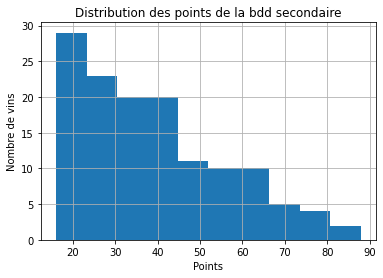

In [132]:
data_annexe2['score'].hist()
plt.xlabel('Points')
plt.ylabel('Nombre de vins')
plt.title('Distribution des points de la bdd secondaire')

La distribution des points ne ressemble pas à celle de notre base de données principale. Ce qui peut notamment s'expliquer par le peu de données présentes dans notre base de données secondaire

Nous avons donc réussi, comme un consommateur lambda qui utiliserait se modèle sur un vin en magasin, à déterminer la note des vins qui sont présents dans la base de données secondaire.

# Conclusion


Le modèle donne déjà des résultats plutôt convaincants!
Cependant il existe encore de nombreuses pistes d'améliorations...
On pourrait se servir du prix pour mieux déterminer le score ou du score pour mieux déterminer le prix.
Il est également possible de prendre en compte l'auteur de la critique pour améliorer la prédiction.

Un autre problème du modèle et la difficulté qu'il a à prédire les prix extremes. Si nous nous intéressons à des bouteilles de très hautes qualité il devient rapidement inutile.

Globalement, ce modèle s'adresse à des acheteurs lambda qui doivent se forger rapidement une opinion d'une bouteille à partir d'une descrpition succinte.